# Visualization of b2

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
import pandas as pd
import unicodedata
import string
import re
import random
import copy
from contra_qa.plots.functions  import simple_step_plot, plot_confusion_matrix
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from nltk.translate.bleu_score import sentence_bleu


% matplotlib inline

In [2]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return '%s' % asMinutes(s)

### Preparing data

In [3]:
df2 = pd.read_csv("data/boolean2_train.csv")
df2_test = pd.read_csv("data/boolean2_test.csv")

df2["text"] = df2["sentence1"] + df2["sentence2"] 
df2_test["text"] = df2_test["sentence1"] + df2_test["sentence2"] 

all_sentences = list(df2.text.values) + list(df2_test.text.values)

df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]

In [4]:
df2train.tail()

,sentence1,sentence2,and_A,and_B,label,text
8495,Agnes is proud and Lauren is ambitious,Agnes is not proud,Agnes is proud,Lauren is ambitious,1,Agnes is proud and Lauren is ambitious Agnes i...
8496,Curtis is wonderful and Jessie is ambitious,Curtis is not wonderful,Curtis is wonderful,Jessie is ambitious,1,Curtis is wonderful and Jessie is ambitious Cu...
8497,Brett is dead and Tracy is important,Tracy is not important,Brett is dead,Tracy is important,1,Brett is dead and Tracy is important Tracy is ...
8498,Lauren is hallowed and Yvette is shy,Yvette is not shy,Lauren is hallowed,Yvette is shy,1,Lauren is hallowed and Yvette is shy Yvette is...
8499,Kathleen is alive and Dustin is clever,Dustin is not clever,Kathleen is alive,Dustin is clever,1,Kathleen is alive and Dustin is clever Dustin ...


In [5]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


example = "ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf"
print("Before:", example)
print()
print("After:", normalizeString(example))

Before: ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf

After: ddddda capoeeeeeee ! ! aas fdf


In [7]:
pairs_A = list(zip(list(df2train.sentence1.values), list(df2train.and_A.values)))
pairs_B = list(zip(list(df2train.sentence1.values), list(df2train.and_B.values)))
pairs_A = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A]
pairs_B = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B]
pairs_A_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_A.values)))
pairs_B_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_B.values)))
pairs_A_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A_val]
pairs_B_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B_val]


In [8]:
all_text_pairs = zip(all_sentences, all_sentences)
all_text_pairs = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in all_text_pairs]

In [9]:
def readLangs(lang1, lang2, pairs, reverse=False):
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [tuple(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [10]:
MAX_LENGTH = 20

def filterPair(p):
    cond1 = len(p[0].split(' ')) < MAX_LENGTH
    cond2 = len(p[1].split(' ')) < MAX_LENGTH 
    return cond1 and cond2

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [11]:
def prepareData(lang1, lang2, pairs, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, pairs, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [12]:
_, _, training_pairs_A = prepareData("eng_enc",
                                             "eng_dec",
                                             pairs_A)

print()


input_lang, _, _ = prepareData("eng_enc",
                               "eng_dec",
                               all_text_pairs)

output_lang = copy.deepcopy(input_lang)

print()

print()
_, _, valid_pairs_A = prepareData("eng_enc",
                                "eng_dec",
                                pairs_A_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 705
eng_dec 704

Read 11000 sentence pairs
Trimmed to 11000 sentence pairs
Counting words...
Counted words:
eng_enc 706
eng_dec 706


Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 696
eng_dec 644


In [13]:
_, _, training_pairs_B = prepareData("eng_enc",
                                     "eng_dec",
                                     pairs_B)
print()
_, _, valid_pairs_B = prepareData("eng_enc",
                                "eng_dec",
                                pairs_B_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 705
eng_dec 704

Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 696
eng_dec 638


### sentences 2 tensors

In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [15]:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [16]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [17]:
def tensorsFromTriple(triple):
    input_tensor = tensorFromSentence(input_lang, triple[0])
    target_tensor = tensorFromSentence(output_lang, triple[1])
    label_tensor = torch.tensor(triple[2], dtype=torch.long).view((1))
    return (input_tensor, target_tensor, label_tensor)

### models

In [18]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [19]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
hidden_size = 100
eng_enc_v_size = input_lang.n_words
eng_dec_v_size = output_lang.n_words

In [21]:
encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = DecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("encoder4.pkl"))
decoderA.load_state_dict(torch.load("decoder4.pkl"))

In [22]:
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = DecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("encoder5.pkl"))
decoderB.load_state_dict(torch.load("decoder5.pkl"))

## translating

In [23]:
def translate(encoder,
              decoder,
              sentence,
              max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()

        return " ".join(decoded_words)

## translation of a trained model: and A

In [24]:
for t in training_pairs_A[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoderA,
                                   decoderA,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

input_sentence : penny is thankful and naomi is alive
neural translation : blanche is thankful <EOS>
reference translation : penny is thankful <EOS>
blue score = 0.71

input_sentence : carlos is kind and paula is uninterested
neural translation : carlos is kind <EOS>
reference translation : carlos is kind <EOS>
blue score = 1.00

input_sentence : jack is hallowed and kent is easy
neural translation : jack is hallowed <EOS>
reference translation : jack is hallowed <EOS>
blue score = 1.00



/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


## translation of a trained model: and B

In [25]:
for t in training_pairs_B[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoderB,
                                   decoderB,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

input_sentence : penny is thankful and naomi is alive
neural translation : naomi is alive <EOS>
reference translation : naomi is alive <EOS>
blue score = 1.00

input_sentence : carlos is kind and paula is uninterested
neural translation : paula is uninterested <EOS>
reference translation : paula is uninterested <EOS>
blue score = 1.00

input_sentence : jack is hallowed and kent is easy
neural translation : kent is easy <EOS>
reference translation : kent is easy <EOS>
blue score = 1.00



In [26]:
valid_triples = zip(list(df2valid.sentence1.values), list(df2valid.sentence2.values), list(df2valid.label.values))
valid_triples = [(normalizeString(s1), normalizeString(s2), l) for s1, s2, l in valid_triples]
valid_triples_t = [tensorsFromTriple(t) for t in valid_triples]

# Models

In [27]:
class AndModelZero(nn.Module):
    def __init__(self,
                 encoderA,
                 decoderA,
                 encoderB,
                 decoderB,
                 hidden_size,
                 output_size,
                 max_length,
                 input_lang,
                 target_lang,
                 SOS_token=0,
                 EOS_token=1):
        super(AndModelZero, self).__init__()
        self.max_length = max_length
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoderA = encoderA
        self.decoderA = decoderA
        self.encoderB = encoderB
        self.decoderB = decoderB
        self.input_lang = input_lang
        self.target_lang = target_lang
        self.SOS_token = SOS_token
        self.EOS_token = EOS_token
        self.fc_inf = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
        
    
    def encode(self,
               sentence,
               encoder,
               is_tensor,
               hidden=None):
        if not is_tensor:
            input_tensor = tensorFromSentence(self.input_lang, sentence)
        else:
            input_tensor = sentence

        input_length = input_tensor.size()[0]
        
        if hidden is None:
            encoder_hidden = encoder.initHidden()
        else:
            encoder_hidden = hidden
            
        outs = []
            
        
        for ei in range(input_length):
            output, encoder_hidden = encoder(input_tensor[ei],
                                        encoder_hidden)
            outs.append(output)
        
        self.output = torch.stack(outs)
        self.output = self.output.view((input_length, self.hidden_size))
        return encoder_hidden
    
    
    def decode(self,
               tensor,
               decoder,
               out_tensor):
        
        decoder_input = torch.tensor([[self.SOS_token]], device=device)
        decoder_hidden = tensor
        decoded_words = []

        for di in range(self.max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == self.EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(self.target_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()
        
        if not out_tensor:
            output = " ".join(decoded_words)
        else:
            output = decoder_hidden

        return output
    
    def sen2vec(self, sentence, encoder, decoder, is_tensor, out_tensor):
        encoded = self.encode(sentence, encoder, is_tensor)
        vec = self.decode(encoded, decoder, out_tensor)
        return vec
    
    def sen2vecA(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderA, is_tensor)
        vec = self.decode(encoded, self.decoderA, out_tensor=True)
        return vec
    
    def sen2vecB(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderB, is_tensor)
        vec = self.decode(encoded, self.decoderB, out_tensor=True)
        return vec
    
    def forward(self, s1, s2):
        hA = self.sen2vecA(s1, is_tensor=True)
        hB = self.sen2vecB(s1, is_tensor=True)

        h_inf = None

        e = self.encode(s2,
                        self.encoderA,
                        hidden=h_inf,
                        is_tensor=True)
        output = self.fc_out(e).squeeze(1)
        
        return output
    

    def predict(self, s1, s2):
        out = self.forward(s1, s2)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

        


In [28]:
class AndModelB(nn.Module):
    def __init__(self,
                 encoderA,
                 decoderA,
                 encoderB,
                 decoderB,
                 hidden_size,
                 output_size,
                 max_length,
                 input_lang,
                 target_lang,
                 SOS_token=0,
                 EOS_token=1):
        super(AndModelB, self).__init__()
        self.max_length = max_length
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoderA = encoderA
        self.decoderA = decoderA
        self.encoderB = encoderB
        self.decoderB = decoderB
        self.input_lang = input_lang
        self.target_lang = target_lang
        self.SOS_token = SOS_token
        self.EOS_token = EOS_token
        self.fc_inf = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
        
    
    def encode(self,
               sentence,
               encoder,
               is_tensor,
               hidden=None):
        if not is_tensor:
            input_tensor = tensorFromSentence(self.input_lang, sentence)
        else:
            input_tensor = sentence

        input_length = input_tensor.size()[0]
        
        if hidden is None:
            encoder_hidden = encoder.initHidden()
        else:
            encoder_hidden = hidden
            
        outs = []
            
        
        for ei in range(input_length):
            output, encoder_hidden = encoder(input_tensor[ei],
                                        encoder_hidden)
            outs.append(output)
        
        self.output = torch.stack(outs)
        self.output = self.output.view((input_length, self.hidden_size))
        return encoder_hidden
    
    
    def decode(self,
               tensor,
               decoder,
               out_tensor):
        
        decoder_input = torch.tensor([[self.SOS_token]], device=device)
        decoder_hidden = tensor
        decoded_words = []

        for di in range(self.max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == self.EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(self.target_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()
        
        if not out_tensor:
            output = " ".join(decoded_words)
        else:
            output = decoder_hidden

        return output
    
    def sen2vec(self, sentence, encoder, decoder, is_tensor, out_tensor):
        encoded = self.encode(sentence, encoder, is_tensor)
        vec = self.decode(encoded, decoder, out_tensor)
        return vec
    
    def sen2vecA(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderA, is_tensor)
        vec = self.decode(encoded, self.decoderA, out_tensor=True)
        return vec
    
    def sen2vecB(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderB, is_tensor)
        vec = self.decode(encoded, self.decoderB, out_tensor=True)
        return vec
    
    def forward(self, s1, s2):
        hA = self.sen2vecA(s1, is_tensor=True)
        hB = self.sen2vecB(s1, is_tensor=True)

        h_inf = hB

        e = self.encode(s2,
                        self.encoderA,
                        hidden=h_inf,
                        is_tensor=True)
        output = self.fc_out(e).squeeze(1)
        
        return output
    

    def predict(self, s1, s2):
        out = self.forward(s1, s2)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

        


In [29]:
class AndModelA(nn.Module):
    def __init__(self,
                 encoderA,
                 decoderA,
                 encoderB,
                 decoderB,
                 hidden_size,
                 output_size,
                 max_length,
                 input_lang,
                 target_lang,
                 SOS_token=0,
                 EOS_token=1):
        super(AndModelA, self).__init__()
        self.max_length = max_length
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoderA = encoderA
        self.decoderA = decoderA
        self.encoderB = encoderB
        self.decoderB = decoderB
        self.input_lang = input_lang
        self.target_lang = target_lang
        self.SOS_token = SOS_token
        self.EOS_token = EOS_token
        self.fc_inf = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
        
    
    def encode(self,
               sentence,
               encoder,
               is_tensor,
               hidden=None):
        if not is_tensor:
            input_tensor = tensorFromSentence(self.input_lang, sentence)
        else:
            input_tensor = sentence

        input_length = input_tensor.size()[0]
        
        if hidden is None:
            encoder_hidden = encoder.initHidden()
        else:
            encoder_hidden = hidden
            
        outs = []
            
        
        for ei in range(input_length):
            output, encoder_hidden = encoder(input_tensor[ei],
                                        encoder_hidden)
            outs.append(output)
        
        self.output = torch.stack(outs)
        self.output = self.output.view((input_length, self.hidden_size))
        return encoder_hidden
    
    
    def decode(self,
               tensor,
               decoder,
               out_tensor):
        
        decoder_input = torch.tensor([[self.SOS_token]], device=device)
        decoder_hidden = tensor
        decoded_words = []

        for di in range(self.max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == self.EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(self.target_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()
        
        if not out_tensor:
            output = " ".join(decoded_words)
        else:
            output = decoder_hidden

        return output
    
    def sen2vec(self, sentence, encoder, decoder, is_tensor, out_tensor):
        encoded = self.encode(sentence, encoder, is_tensor)
        vec = self.decode(encoded, decoder, out_tensor)
        return vec
    
    def sen2vecA(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderA, is_tensor)
        vec = self.decode(encoded, self.decoderA, out_tensor=True)
        return vec
    
    def sen2vecB(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderB, is_tensor)
        vec = self.decode(encoded, self.decoderB, out_tensor=True)
        return vec
    
    def forward(self, s1, s2):
        hA = self.sen2vecA(s1, is_tensor=True)
        hB = self.sen2vecB(s1, is_tensor=True)

        h_inf = hA

        e = self.encode(s2,
                        self.encoderA,
                        hidden=h_inf,
                        is_tensor=True)
        output = self.fc_out(e).squeeze(1)
        
        return output
    

    def predict(self, s1, s2):
        out = self.forward(s1, s2)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

        


In [30]:
class AndModelDot(nn.Module):
    def __init__(self,
                 encoderA,
                 decoderA,
                 encoderB,
                 decoderB,
                 hidden_size,
                 output_size,
                 max_length,
                 input_lang,
                 target_lang,
                 SOS_token=0,
                 EOS_token=1):
        super(AndModelDot, self).__init__()
        self.max_length = max_length
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoderA = encoderA
        self.decoderA = decoderA
        self.encoderB = encoderB
        self.decoderB = decoderB
        self.input_lang = input_lang
        self.target_lang = target_lang
        self.SOS_token = SOS_token
        self.EOS_token = EOS_token
        self.fc_out = nn.Linear(hidden_size, output_size)
        
    
    def encode(self,
               sentence,
               encoder,
               is_tensor,
               hidden=None):
        if not is_tensor:
            input_tensor = tensorFromSentence(self.input_lang, sentence)
        else:
            input_tensor = sentence

        input_length = input_tensor.size()[0]
        
        if hidden is None:
            encoder_hidden = encoder.initHidden()
        else:
            encoder_hidden = hidden
            
        outs = []
            
        
        for ei in range(input_length):
            output, encoder_hidden = encoder(input_tensor[ei],
                                        encoder_hidden)
            outs.append(output)
        
        self.output = torch.stack(outs)
        self.output = self.output.view((input_length, self.hidden_size))
        return encoder_hidden
    
    
    def decode(self,
               tensor,
               decoder,
               out_tensor):
        
        decoder_input = torch.tensor([[self.SOS_token]], device=device)
        decoder_hidden = tensor
        decoded_words = []

        for di in range(self.max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == self.EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(self.target_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()
        
        if not out_tensor:
            output = " ".join(decoded_words)
        else:
            output = decoder_hidden

        return output
    
    def sen2vec(self, sentence, encoder, decoder, is_tensor, out_tensor):
        encoded = self.encode(sentence, encoder, is_tensor)
        vec = self.decode(encoded, decoder, out_tensor)
        return vec
    
    def sen2vecA(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderA, is_tensor)
        vec = self.decode(encoded, self.decoderA, out_tensor=True)
        return vec
    
    def sen2vecB(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderB, is_tensor)
        vec = self.decode(encoded, self.decoderB, out_tensor=True)
        return vec
    
    def forward(self, s1, s2):
        hA = self.sen2vecA(s1, is_tensor=True)
        hB = self.sen2vecB(s1, is_tensor=True)

        h_inf = hA * hB

        e = self.encode(s2,
                        self.encoderA,
                        hidden=h_inf,
                        is_tensor=True)
        output = self.fc_out(e).squeeze(1)
        
        return output
    

    def predict(self, s1, s2):
        out = self.forward(s1, s2)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

        


In [31]:
addmodel = AndModelB(encoderA,
                    decoderA,
                     encoderB,
                     decoderB,
                     hidden_size=100,
                     output_size=2,
                     max_length=MAX_LENGTH,
                     input_lang=input_lang,
                     target_lang=output_lang)

In [32]:
for ex in training_pairs_B[0:3]:
    print("===========")
    ex = ex[0]
    print("s1:\n")
    print(ex)
    print()

    
    ex_A = addmodel.sen2vec(ex,
                     addmodel.encoderA,
                     addmodel.decoderA,
                     is_tensor=False,
                     out_tensor=False)
    
    ex_B = addmodel.sen2vec(ex,
                     addmodel.encoderB,
                     addmodel.decoderB,
                     is_tensor=False,
                     out_tensor=False)

    print("inference A:\n")
    print(ex_A)
    print()
    print("inference B:\n")
    print(ex_B)

s1:

penny is thankful and naomi is alive

inference A:

blanche is thankful <EOS>

inference B:

naomi is alive <EOS>
s1:

carlos is kind and paula is uninterested

inference A:

carlos is kind <EOS>

inference B:

paula is uninterested <EOS>
s1:

jack is hallowed and kent is easy

inference A:

jack is hallowed <EOS>

inference B:

kent is easy <EOS>


Visualization

In [33]:
def sentence_plot(sentences, values, title=None):
    """
    plot the values of one dimension of the hidden vector to
    each word in the sentence.

    :param sentences: sentences to be printed
    :type sentences: list of str 
    :param values: one dimension of the hidden vector 
                   for each word of the sentence
    :type values: np.array(shape=(num_sentences, sent_len))
    """
    assert len(sentences) == values.shape[0]
    for sentence in sentences:
        assert len(sentence.split()) == values.shape[1]

    all_values = []
    sentence_size = np.max([len(sentence) for sentence in sentences])
    for sid, sentence in enumerate(sentences):
        temp = np.zeros((sentence_size))
        count = 0
        for wid, word in enumerate(sentence.split()):
            temp[count: count + len(word)] = values[sid][wid]
            count = count + len(word) + 1
        all_values.append(temp)
    all_values = np.array(all_values)

    height = all_values.shape[0] 
    width = all_values.shape[1]
    
    plt.figure(figsize=(width * 1.6, height * 0.3))
    plt.title(title)
    plt.imshow(all_values, interpolation='none',
             cmap='Oranges')
    plt.axis('off')
    for sid, sentence in enumerate(sentences):
        for wid, word in enumerate(sentence):
            plt.text(wid-0.2,sid+0.2,word,color='k',fontsize=12)

    plt.show()
    plt.close()

In [34]:
encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = DecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("encoder4.pkl"))
decoderA.load_state_dict(torch.load("decoder4.pkl"))
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = DecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("encoder5.pkl"))
decoderB.load_state_dict(torch.load("decoder5.pkl"))

In [35]:
addmodel = AndModelB(encoderA,
                    decoderA,
                     encoderB,
                     decoderB,
                     hidden_size=100,
                     output_size=2,
                     max_length=MAX_LENGTH,
                     input_lang=input_lang,
                     target_lang=output_lang)

addmodel.load_state_dict(torch.load("b2_simpleB.pkl"))

Using only one example

In [36]:
sent_and_triples = list(zip(valid_triples, valid_triples_t))
valid_examples = [random.choice(sent_and_triples) for i in range(1)]

In [37]:
valid_examples_sen = [i[0][1] for i in valid_examples]
valid_examples_s1_s2 = [(i[1][0], i[1][1]) for i in valid_examples]

In [38]:
for t in valid_examples:
    print(t[0])
    s1 = t[1][0]
    s2 = t[1][1]
    for i in s1:
        print(input_lang.index2word[i.item()], end = " ")
    print()
    for i in s2:
        print(input_lang.index2word[i.item()], end = " ")
    print()

('cory is witty and dale is faithful', 'delores is hallowed', 0)
cory is witty and dale is faithful EOS 
delores is hallowed EOS 


In [39]:
example = valid_examples[0]

In [40]:
sen = example[0][1]

In [41]:
s1, s2 = example[1][0], example[1][1]

In [42]:
encodings = []

# for tuple_ in valid_examples_s1_s2:
addmodel(s1, s2)
encodings.append(addmodel.output[:-1])

In [43]:
encod_ = encodings[0].unsqueeze(0)

In [44]:
encod_.shape

torch.Size([1, 3, 100])

In [45]:
encod_ = encod_.detach().numpy()

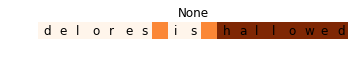

In [46]:
sentence_plot([sen], encod_[:,:,20])

Using a batch of examples

In [47]:
valid_examples = [random.choice(sent_and_triples) for i in range(10)]

valid_examples_sen = [i[0][1] for i in valid_examples]
valid_examples_s1_s2 = [(i[1][0], i[1][1]) for i in valid_examples]

In [48]:
encodings = []

for tuple_ in valid_examples_s1_s2:
    s1, s2 = tuple_
    addmodel(s1, s2)
    encodings.append(addmodel.output[:-1].detach().numpy())

In [49]:
for i,e in zip(valid_examples_sen, encodings):
    print(i, len(i.split(" ")), e.shape)

derek is not helpful 4 (4, 100)
gail is not agreeable 4 (4, 100)
claire is not careful 4 (4, 100)
june is not happy 4 (4, 100)
jon is vast 3 (3, 100)
bernice is not easy 4 (4, 100)
cecilia is not obedient 4 (4, 100)
jamie is not clever 4 (4, 100)
molly is not agreeable 4 (4, 100)
donna is better 3 (3, 100)


In [50]:
from sklearn.decomposition import PCA
projector = 'PCA' #@param ['PCA', 'TSNE', 'Isomap']
projector_fun = eval(projector)

kwargs = {
    'TSNE': {'perplexity': 5},
    'PCA': {},
    'Isomap': {}
}

projector = projector_fun(n_components=3, **kwargs[projector])

In [51]:
new = []
for array in encodings:
    new.append(projector.fit_transform(array))    

In [52]:
for i,e in zip(valid_examples_sen, new):
    print(i, len(i.split(" ")), e.shape)

derek is not helpful 4 (4, 3)
gail is not agreeable 4 (4, 3)
claire is not careful 4 (4, 3)
june is not happy 4 (4, 3)
jon is vast 3 (3, 3)
bernice is not easy 4 (4, 3)
cecilia is not obedient 4 (4, 3)
jamie is not clever 4 (4, 3)
molly is not agreeable 4 (4, 3)
donna is better 3 (3, 3)


In [53]:
max_size = np.max([len(sentence.split()) for sentence in valid_examples_sen])

In [54]:
new_p = []
for array in new:
    size = array.shape[0]
    if size < max_size:
        zero = np.zeros((1, array.shape[1]))
        array_p = np.concatenate([array, zero])
        new_p.append(array_p)
    else:
        new_p.append(array)

In [55]:
valid_examples_sen_p = []
for sen in valid_examples_sen:
    size = len(sen.split(" "))
    if size < max_size:
        sen += " <pad>"
        valid_examples_sen_p.append(sen)
    else:
        valid_examples_sen_p.append(sen)

In [56]:
for i,e in zip(valid_examples_sen_p, new_p):
    print(i, len(i.split(" ")), e.shape)

derek is not helpful 4 (4, 3)
gail is not agreeable 4 (4, 3)
claire is not careful 4 (4, 3)
june is not happy 4 (4, 3)
jon is vast <pad> 4 (4, 3)
bernice is not easy 4 (4, 3)
cecilia is not obedient 4 (4, 3)
jamie is not clever 4 (4, 3)
molly is not agreeable 4 (4, 3)
donna is better <pad> 4 (4, 3)


In [57]:
valid_encodings = np.stack(new_p)

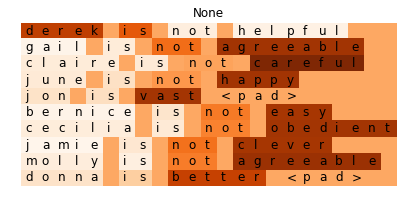

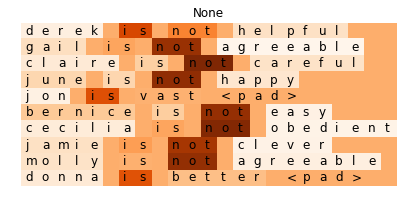

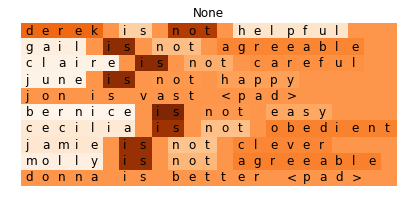

In [58]:
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,0])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,1])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,2])

Applying a function to a fixed set of sentences 

In [59]:
valid_examples = [sent_and_triples[i] for i in [1, 0, 1120, 1118, 1379, 788, 313, 350, 755, 1062]]

valid_examples_sen = [i[0][1] for i in valid_examples]
valid_examples_s1_s2 = [(i[1][0], i[1][1]) for i in valid_examples]

In [60]:
def transform_to_plot(valid_examples_sen, valid_examples_s1_s2, model):

    max_size = np.max([len(sentence.split()) for sentence in valid_examples_sen])
    encodings = []

    for tuple_ in valid_examples_s1_s2:
        s1, s2 = tuple_
        model(s1, s2)
        encodings.append(model.output[:-1].detach().numpy())

    new = []

    for array in encodings:
        new.append(projector.fit_transform(array))    

    new_p = []

    for array in new:
        size = array.shape[0]
        if size < max_size:
            zero = np.zeros((1, array.shape[1]))
            array_p = np.concatenate([array, zero])
            new_p.append(array_p)
        else:
            new_p.append(array)

    valid_examples_sen_p = []

    for sen in valid_examples_sen:
        size = len(sen.split(" "))
        if size < max_size:
            sen += " <pad>"
            valid_examples_sen_p.append(sen)
        else:
            valid_examples_sen_p.append(sen)

    valid_encodings = np.stack(new_p)
    
    return valid_examples_sen_p, valid_encodings

In [61]:
valid_examples_sen_p, valid_encodings = transform_to_plot(valid_examples_sen, valid_examples_s1_s2, addmodel)

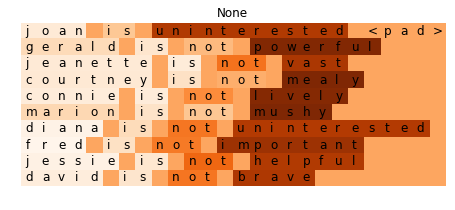

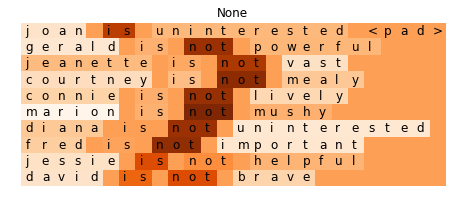

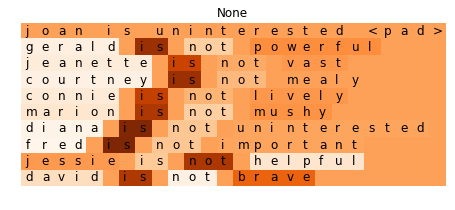

In [62]:
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,0])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,1])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,2])

### Showing results

Fixing results

In [63]:
valid_examples = [sent_and_triples[i] for i in [1, 0, 1120, 1118, 1379, 788, 313, 350, 755, 1062]]

valid_examples_sen = [i[0][1] for i in valid_examples]

valid_examples_sen1 = [i[0][0] for i in valid_examples]

valid_examples_s1_s2 = [(i[1][0], i[1][1]) for i in valid_examples]

In [64]:
for i, e in zip(valid_examples_sen1, valid_examples_sen):
    print(i)
    print(e)
    print()

kristin is agreeable and ellen is aggressive
joan is uninterested

chris is wrong and gerald is powerful
gerald is not powerful

jeanette is delightful and vernon is vast
jeanette is not vast

penny is calm and salvador is zealous
courtney is not mealy

connie is lively and wayne is witty
connie is not lively

rebecca is mushy and marion is mushy
marion is not mushy

herman is important and diana is uninterested
diana is not uninterested

rosemary is careful and fred is important
fred is not important

jessie is agreeable and leona is helpful
jessie is not helpful

willie is brave and david is rich
david is not brave



# Zero model (enconding starting with zero)

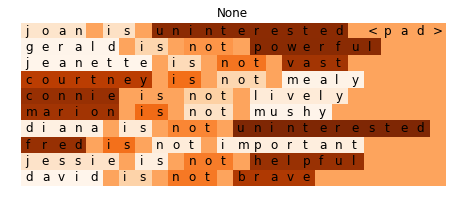

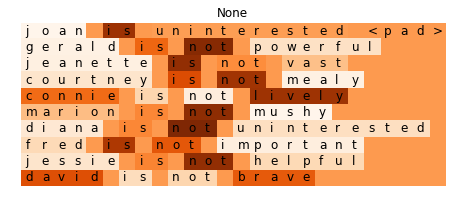

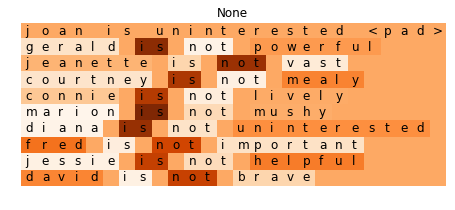

In [65]:
encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = DecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("encoder4.pkl"))
decoderA.load_state_dict(torch.load("decoder4.pkl"))
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = DecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("encoder5.pkl"))
decoderB.load_state_dict(torch.load("decoder5.pkl"))

addmodelzero = AndModelZero(encoderA,
                        decoderA,
                     encoderB,
                     decoderB,
                     hidden_size=100,
                     output_size=2,
                     max_length=MAX_LENGTH,
                     input_lang=input_lang,
                     target_lang=output_lang)

# addmodel.load_state_dict(torch.load("b2_simpleB.pkl"))

valid_examples_sen_p, valid_encodings = transform_to_plot(valid_examples_sen,
                                                          valid_examples_s1_s2,
                                                          addmodelzero)

sentence_plot(valid_examples_sen_p, valid_encodings[:,:,0])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,1])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,2])

# Model with only the first projection

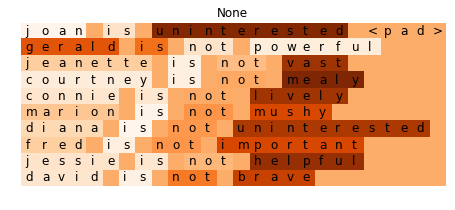

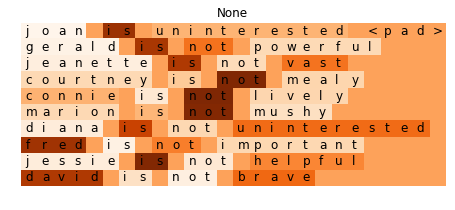

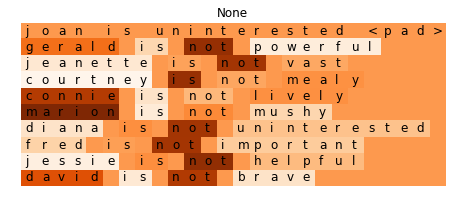

In [66]:
encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = DecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("encoder4.pkl"))
decoderA.load_state_dict(torch.load("decoder4.pkl"))
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = DecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("encoder5.pkl"))
decoderB.load_state_dict(torch.load("decoder5.pkl"))

addmodelA = AndModelA(encoderA,
                        decoderA,
                     encoderB,
                     decoderB,
                     hidden_size=100,
                     output_size=2,
                     max_length=MAX_LENGTH,
                     input_lang=input_lang,
                     target_lang=output_lang)

addmodelA.load_state_dict(torch.load("b2_simpleA.pkl"))

valid_examples_sen_p, valid_encodings = transform_to_plot(valid_examples_sen,
                                                          valid_examples_s1_s2,
                                                          addmodelA)

sentence_plot(valid_examples_sen_p, valid_encodings[:,:,0])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,1])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,2])

# Model with only the second projection

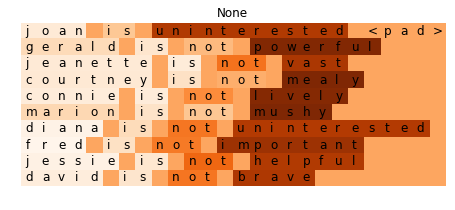

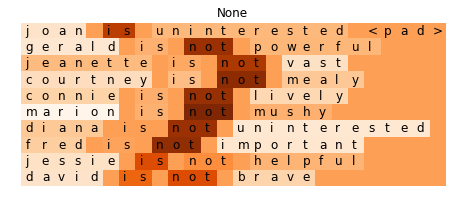

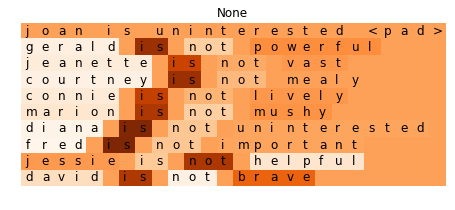

In [67]:
encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = DecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("encoder4.pkl"))
decoderA.load_state_dict(torch.load("decoder4.pkl"))
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = DecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("encoder5.pkl"))
decoderB.load_state_dict(torch.load("decoder5.pkl"))

addmodelB = AndModelB(encoderA,
                        decoderA,
                     encoderB,
                     decoderB,
                     hidden_size=100,
                     output_size=2,
                     max_length=MAX_LENGTH,
                     input_lang=input_lang,
                     target_lang=output_lang)

addmodelB.load_state_dict(torch.load("b2_simpleB.pkl"))

valid_examples_sen_p, valid_encodings = transform_to_plot(valid_examples_sen,
                                                          valid_examples_s1_s2,
                                                          addmodelB)

sentence_plot(valid_examples_sen_p, valid_encodings[:,:,0])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,1])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,2])

# Model with only the combination of the two projections

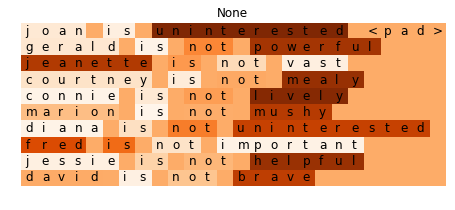

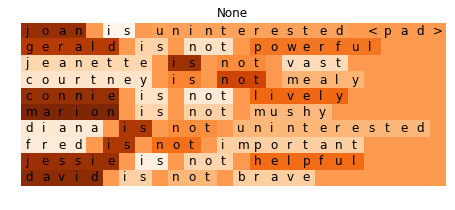

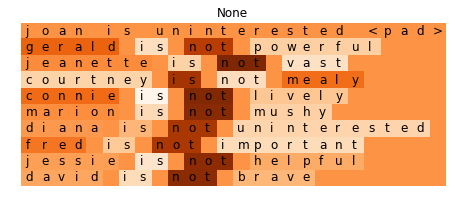

In [68]:
encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = DecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("encoder4.pkl"))
decoderA.load_state_dict(torch.load("decoder4.pkl"))
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = DecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("encoder5.pkl"))
decoderB.load_state_dict(torch.load("decoder5.pkl"))

addmodeldot = AndModelDot(encoderA,
                        decoderA,
                     encoderB,
                     decoderB,
                     hidden_size=100,
                     output_size=2,
                     max_length=MAX_LENGTH,
                     input_lang=input_lang,
                     target_lang=output_lang)

addmodeldot.load_state_dict(torch.load("b2_dot.pkl"))

valid_examples_sen_p, valid_encodings = transform_to_plot(valid_examples_sen,
                                                          valid_examples_s1_s2,
                                                          addmodeldot)

sentence_plot(valid_examples_sen_p, valid_encodings[:,:,0])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,1])
sentence_plot(valid_examples_sen_p, valid_encodings[:,:,2])